## **Nome:** Anakin Dantas Rodrigues \

## **Matrícula:** 2023033173

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.optimize import curve_fit
from numba import jit
import pandas as pd

# Rotinas Ising

In [3]:
@jit(nopython=True)
def estado_ini(N):
    #Gera um estadon inicial aleatório para rede
    s = np.zeros(N,dtype=np.int8)
    for i in range(N):
        s[i] = np.sign(2*np.random.random()-1)
    return s

In [4]:
@jit(nopython=True)
def vizinhos(N):

    #Define a tabela de vizinhos
    L=int(np.sqrt(N))

    viz = np.zeros((N,4),dtype=np.int16)

    for k in range(N):
        viz[k,0]=k+1                        # Define vizinho a direita
        if (k+1) % L == 0: viz[k,0] = k+1-L # Aplica condicao de contorno
        viz[k,1] = k+L                      # Define vizinho acima
        if k > (N-L-1): viz[k,1] = k+L-N    # Aplica condicao de contorno
        viz[k,2] = k-1                      # Define vizinho a esquerda
        if (k % L == 0): viz[k,2] = k+L-1   # Aplica condicao de contorno
        viz[k,3] = k-L                      # Define vizinho abaixo
        if k < L: viz[k,3] = k+N-L          # Aplica condicao de contorno

    return viz

In [5]:
@jit(nopython=True)
def energia(s,viz):
    #Calcula a energia da configuração s
    N=len(s)
    ener = 0
    for i in range(N):
        h = s[viz[i,0]]+s[viz[i,1]]
        ener -= s[i]*h
    return ener

In [6]:
@jit(nopython=True)
def expos(beta):
    # Define o valor das exponenciais que são usadas durante o Monte Carlo
    # beta é o inverso da temperatura
    # O argumento pode ser obtido calculando
    #       h = s[viz[i,0]]+s[viz[i,1]]+s[viz[i,2]]+s[viz[i,3]]
    #       de = int(s[i]*h*0.5+2)
    #   que fornece os valores 0, 1, 2, 3, 4 para diferenças de energia
    #   iguais a -8, -4, 0, 4, 8, respectivamente.
    ex = np.zeros(5,dtype=np.float32)
    ex[0]=np.exp(8.0*beta)
    ex[1]=np.exp(4.0*beta)
    ex[2]=1.0
    ex[3]=np.exp(-4.0*beta)
    ex[4]=np.exp(-8.0*beta)
    return ex

# Prova de que só existem 5 valores possíveis para diferença de energia ao flipar um spin: −8, −4, 0, 4 e 8

In [21]:
L = 5
N = L*L

@jit(nopython=True)
def valoresPossiveis(N):
    s = estado_ini(N)
    viz = vizinhos(N)

    oito = 0
    quatro = 0
    zero = 0
    quatro_neg = 0
    oito_neg = 0
    outro = 0

    for i in range(N):
        h = s[viz[i, 0]] + s[viz[i, 1]] + s[viz[i, 2]] + s[viz[i, 3]]
        deltaE = - (2 * s[i] * h)

        if deltaE == -8:
            oito_neg += 1
        elif deltaE == -4:
            quatro_neg += 1
        elif deltaE == 0:
            zero += 1
        elif deltaE == 4:
            quatro += 1
        elif deltaE == 8:
            oito += 1
        else:
            outro += 1

    return oito, quatro, zero, quatro_neg, oito_neg, outro


# Inicializar acumuladores
oito_total = 0
quatro_total = 0
zero_total = 0
quatro_neg_total = 0
oito_neg_total = 0

for n in range(1000000):
  oito, quatro, zero, quatro_neg, oito_neg, outro = valoresPossiveis(N)
  oito_total += oito
  quatro_total += quatro
  zero_total += zero
  quatro_neg_total += quatro_neg
  oito_neg_total += oito_neg

# Resultado final
print("Total de outros valores encontrados: ", outro)
print("Total oito: ", oito_total)
print("Total quatro: ", quatro_total)
print("Total zero: ", zero_total)
print("Total quatro negativo: ", quatro_neg_total)
print("Total oito negativo: ", oito_neg_total)

Total de outros valores encontrados:  0
Total oito:  1561919
Total quatro:  6248398
Total zero:  9376862
Total quatro negativo:  6249130
Total oito negativo:  1563691


# Algoritmo de Metropolis



Como vimos, a taxa de transição dada por P(μ → ν) = e−β(Eν−Eμ), se Eν − Eμ > 0 e 1 caso contrário.

Permite gerar uma cadeia de Markov onde após o descarte de um número suficientemente grande de passos seremos levados a uma sequência de estados que segue a distribuição de Boltzmann. O algoritmo abaixo, conhecido como algoritmo de Metropolis, mostra como utilizar a prescrição acima para esse fim:

1) Gere uma configuração inicial para o sistema (aleatória, por exemplo).

2) Escolha um dos spins da rede (Si).

3) Determine a diferença de energia caso o spin Si fosse flipado, ΔE.

4) Calcule P = e−βΔE e compare com um número aleatório, r, uniformemente distribuído no intervalo (0, 1).

    a. Se r ≤ P, aceite a nova configuração, ou seja, flipe o spin fazendo Si = −Si.
    b. Se r > P, mantenha o sistema na configuração em que ele se encontrava.

5) Volte ao passo 2.


In [24]:
@jit(nopython=True)
def Metropolis(s,viz,N,ener_atual, mag_atual, exp):

    for i in range (N):

      h = s[viz[i, 0]] + s[viz[i, 1]] + s[viz[i, 2]] + s[viz[i, 3]]
      DeltaE = (2 * s[i] * h)
      de = int(s[i]*h*0.5+2)

      r = np.random.rand()
      if DeltaE < 0:
        P = 1
      else:
        P = exp[de]

      if r <= P:
        s[i] = -s[i]
        ener_atual += DeltaE
        mag_atual += 2*s[i]

    return s, mag_atual, ener_atual

In [25]:
@jit(nopython=True)
def monteCarlo(s, viz, passos, N, exp):
    # Inicializa Energia e Magnetização
    ener_atual = energia(s, viz)
    mag_atual = np.sum(s)

    energ = np.zeros(passos)
    magn = np.zeros(passos)

    # Loop principal de simulação
    for i in range(passos):
        s, mag_atual, ener_atual = Metropolis(s,viz,N,ener_atual, mag_atual, exp)
        energ[i] = ener_atual
        magn[i] = mag_atual

    return energ, magn

## Reproduzindo o exemplo da atividade

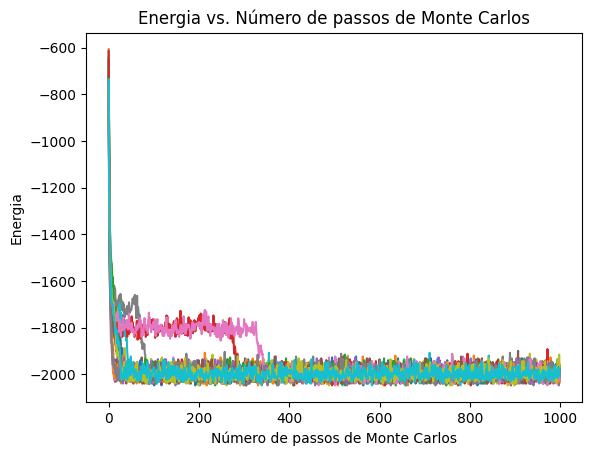

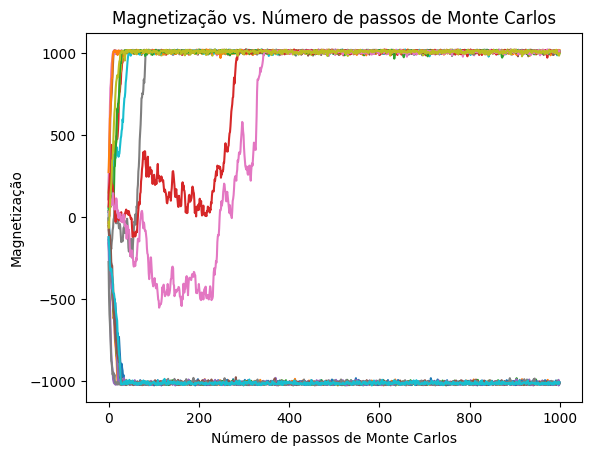

In [ ]:
L = 32
N = L * L
T = 1.5
beta = 1/T
passos = 1000
exp = expos(beta)

seriesE = []
seriesM = []

for x in range(20):
  s = estado_ini(N)
  viz = vizinhos(N)
  exp = expos(beta)
  energ, mag = monteCarlo(s,viz,passos,N,exp)
  seriesE.append(energ)
  seriesM.append(mag)


# Plot Energia series
for x in seriesE:
    plt.plot(x)
plt.title("Energia vs. Número de passos de Monte Carlos")
plt.xlabel("Número de passos de Monte Carlos")
plt.ylabel("Energia")
plt.show()

# Plot Magnetização series
for x in seriesM:
    plt.plot(x)
plt.title("Magnetização vs. Número de passos de Monte Carlos")
plt.xlabel("Número de passos de Monte Carlos")
plt.ylabel("Magnetização")
plt.show()

## Simulando diferentes tamanhos de rede e temperaturas (para análise de dados para a tabela de termalização)

Observação: Eu comentei essa parte do trabalho para que o documento não ficasse muito extenso com todas as saídas explícitas, porém os resultados importantes dos passos necessários até atingir convergência estão na Tabela 1.


In [32]:
# L = 24 # tamanho de rede
# N = L * L
# T = np.array([0.4, 0.8, 1.1, 1.4, 1.75, 2.0, 2.4, 2.7, 3.0]) # Escolhendo temperaturas entre 0.4 e 3.0
# passos = 4000

# for temp in range(len(T)):
#   print('Grade com L=24, Temperatura=',T[temp])
#   beta = 1/T[temp]

#   seriesE24 = []
#   seriesM24 = []

#   for x in range(20):
#     s = estado_ini(N)
#     viz = vizinhos(N)
#     exp = expos(beta)

#     energ, mag = monteCarlo(s,viz,passos,N,exp)
#     seriesE24.append(energ)
#     seriesM24.append(mag)

# # Plot Energia series
#   for x in seriesE24:
#       plt.plot(x)
#   plt.title("Energia vs. Número de passos de Monte Carlos")
#   plt.xlabel("Número de passos de Monte Carlos")
#   plt.ylabel("Energia")
#   plt.show()

#   # Plot Magnetização series
#   for x in seriesM24:
#       plt.plot(x)
#   plt.title("Magnetização vs. Número de passos de Monte Carlos")
#   plt.xlabel("Número de passos de Monte Carlos")
#   plt.ylabel("Magnetização")
#   plt.show()

In [33]:
# L = 32 # tamanho de rede
# N = L * L
# T = np.array([0.4, 0.8, 1.1, 1.4, 1.75, 2.0, 2.4, 2.7, 3.0]) # Escolhendo temperaturas entre 0.4 e 3.0
# passos = 4000

# for temp in range(len(T)):
#   print('Grade com L=',L, 'Temperatura=',T[temp])
#   beta = 1/T[temp]

#   seriesE24 = []
#   seriesM24 = []

#   for x in range(20):
#     s = estado_ini(N)
#     viz = vizinhos(N)
#     exp = expos(beta)

#     energ, mag = monteCarlo(s,viz,passos,N,exp)
#     seriesE24.append(energ)
#     seriesM24.append(mag)

# # Plot Energia series
#   for x in seriesE24:
#       plt.plot(x)
#   plt.title("Energia vs. Número de passos de Monte Carlos")
#   plt.xlabel("Número de passos de Monte Carlos")
#   plt.ylabel("Energia")
#   plt.show()

#   # Plot Magnetização series
#   for x in seriesM24:
#       plt.plot(x)
#   plt.title("Magnetização vs. Número de passos de Monte Carlos")
#   plt.xlabel("Número de passos de Monte Carlos")
#   plt.ylabel("Magnetização")
#   plt.show()

In [34]:
# L = 62 # tamanho de rede
# N = L * L
# T = np.array([0.4, 0.8, 1.1, 1.4, 1.75, 2.0, 2.4, 2.7, 3.0]) # Escolhendo temperaturas entre 0.4 e 3.0
# passos = 10000

# for temp in range(len(T)):
#   print('Grade com L=',L, 'Temperatura=',T[temp])
#   beta = 1/T[temp]

#   seriesE24 = []
#   seriesM24 = []

#   for x in range(20):
#     s = estado_ini(N)
#     viz = vizinhos(N)
#     exp = expos(beta)

#     energ, mag = monteCarlo(s,viz,passos,N,exp)
#     seriesE24.append(energ)
#     seriesM24.append(mag)

# # Plot Energia series
#   for x in seriesE24:
#       plt.plot(x)
#   plt.title("Energia vs. Número de passos de Monte Carlos")
#   plt.xlabel("Número de passos de Monte Carlos")
#   plt.ylabel("Energia")
#   plt.show()

#   # Plot Magnetização series
#   for x in seriesM24:
#       plt.plot(x)
#   plt.title("Magnetização vs. Número de passos de Monte Carlos")
#   plt.xlabel("Número de passos de Monte Carlos")
#   plt.ylabel("Magnetização")
#   plt.show()

In [35]:
# L = 81 # tamanho de rede
# N = L * L
# T = np.array([0.4, 0.8, 1.1, 1.4, 1.75, 2.0, 2.4, 2.7, 3.0]) # Escolhendo temperaturas entre 0.4 e 3.0
# passos = 10000

# for temp in range(len(T)):
#   print('Grade com L=',L, 'Temperatura=',T[temp])
#   beta = 1/T[temp]

#   seriesE24 = []
#   seriesM24 = []

#   for x in range(20):
#     s = estado_ini(N)
#     viz = vizinhos(N)
#     exp = expos(beta)

#     energ, mag = monteCarlo(s,viz,passos,N,exp)
#     seriesE24.append(energ)
#     seriesM24.append(mag)

# # Plot Energia series
#   for x in seriesE24:
#       plt.plot(x)
#   plt.title("Energia vs. Número de passos de Monte Carlos")
#   plt.xlabel("Número de passos de Monte Carlos")
#   plt.ylabel("Energia")
#   plt.show()

#   # Plot Magnetização series
#   for x in seriesM24:
#       plt.plot(x)
#   plt.title("Magnetização vs. Número de passos de Monte Carlos")
#   plt.xlabel("Número de passos de Monte Carlos")
#   plt.ylabel("Magnetização")
#   plt.show()

In [36]:
# L = 100 # tamanho de rede
# N = L * L
# T = np.array([0.4, 0.8, 1.1, 1.4, 1.75, 2.0, 2.4, 2.7, 3.0]) # Escolhendo temperaturas entre 0.4 e 3.0
# passos = 10000

# for temp in range(len(T)):
#   print('Grade com L=',L, 'Temperatura=',T[temp])
#   beta = 1/T[temp]

#   seriesE24 = []
#   seriesM24 = []

#   for x in range(20):
#     s = estado_ini(N)
#     viz = vizinhos(N)
#     exp = expos(beta)

#     energ, mag = monteCarlo(s,viz,passos,N,exp)
#     seriesE24.append(energ)
#     seriesM24.append(mag)

# # Plot Energia series
#   for x in seriesE24:
#       plt.plot(x)
#   plt.title("Energia vs. Número de passos de Monte Carlos")
#   plt.xlabel("Número de passos de Monte Carlos")
#   plt.ylabel("Energia")
#   plt.show()

#   # Plot Magnetização series
#   for x in seriesM24:
#       plt.plot(x)
#   plt.title("Magnetização vs. Número de passos de Monte Carlos")
#   plt.xlabel("Número de passos de Monte Carlos")
#   plt.ylabel("Magnetização")
#   plt.show()

##Tabela com estimativas para o número de passos de Monte Carlo até a termalização

In [27]:
dados = {'Tamanho da grade': [24, 32, 62, 81, 100]*9,
    'Temperatura': sorted([0.4, 0.8, 1.1, 1.4, 1.75, 2.0, 2.4, 2.7, 3.0] * 5),
    'Termalização': [
        'Não convergiu', 'Não convergiu','Não convergiu','Não convergiu','Não convergiu',
        2000, 1200, 'Não convergiu', 'Não convergiu','Não convergiu',
        500, 800, 7500, 9000,'Não convergiu',
        200, 1200, 7500, 7500, 5800,
        200, 200, 3500, 5000, 8000,
        100, 200, 1500, 1000, 2000,
        0, 0, 0, 0, 0,
        0, 0, 0, 0, 0,
        0, 0, 0, 0, 0
        ]
}

tabela = pd.DataFrame(dados)
print('Tabela 1:')
print(tabela.to_string(index=False))

Tabela 1:
 Tamanho da grade  Temperatura  Termalização
               24         0.40 Não convergiu
               32         0.40 Não convergiu
               62         0.40 Não convergiu
               81         0.40 Não convergiu
              100         0.40 Não convergiu
               24         0.80          2000
               32         0.80          1200
               62         0.80 Não convergiu
               81         0.80 Não convergiu
              100         0.80 Não convergiu
               24         1.10           500
               32         1.10           800
               62         1.10          7500
               81         1.10          9000
              100         1.10 Não convergiu
               24         1.40           200
               32         1.40          1200
               62         1.40          7500
               81         1.40          7500
              100         1.40          5800
               24         1.75           200


## Erros Estatísticos

In [28]:
@jit(nopython=True)
def monteCarlo2(s, viz, passos, N, exp, term):
    # Inicializa Energia e Magnetização
    ener_atual = energia(s, viz)
    mag_atual = np.sum(s)

    passos_f = max(1, passos - term)

    # Garante que o tamanho da energ e do magn esteja correto com base no número de etapas após a termalização
    if passos_f <= 0:
        # Retorna arrays vazios para energia e magn, e o estado final s_f
        return np.zeros(0, dtype=np.float64), np.zeros(0, dtype=np.float64), s

    energ = np.zeros(passos_f)
    magn = np.zeros(passos_f)
    data_idx = 0  # Índice para armazenamento de dados após termalização

    # Loop principal de simulação
    for i in range(passos):
        s, mag_atual, ener_atual = Metropolis(s,viz,N,ener_atual, mag_atual, exp)
        if i >= term:
            energ[data_idx] = ener_atual
            magn[data_idx] = mag_atual
            data_idx += 1
    s_f = s # Atualiza o estado atual com base no último estado

    return energ, magn, s_f

@jit(nopython=True)
def tratamentoestatistico(l_val, T_array, N):
    CeMedio_temp = np.zeros(len(T_array))
    SuscepMedio_temp = np.zeros(len(T_array))
    MEmedio_temp = np.zeros(len(T_array))
    MMmedio_temp = np.zeros(len(T_array))
    ErrCe_temp = np.zeros(len(T_array))
    ErrSuscep_temp = np.zeros(len(T_array))
    ErrME_temp = np.zeros(len(T_array))
    ErrMM_temp = np.zeros(len(T_array))

    s = estado_ini(N)
    viz = vizinhos(N)

    # Loop que itera desde a temperatura mais alta para a mais baixa
    for i in range(len(T_array) - 1, -1, -1):
      temp_val = T_array[i]

      beta = 1/temp_val
      exp = expos(beta)

      SeriesCe = np.zeros(20)
      SeriesSuscep = np.zeros(20)

      SeriesME = np.zeros(20)
      SeriesME2 = np.zeros(20)

      SeriesMM = np.zeros(20)
      SeriesMM2 = np.zeros(20)


      for n in range(20):
        passos = int(10000/(n+1))
        term = termalizacao(l_val, temp_val, passos)

        energ, magn, s_f = monteCarlo2(s,viz,passos,N,exp, term)

        # Verifique se a energ e magn estão vazios após a termalização
        if len(energ) > 0:
          mediaE = np.mean(energ/N) #Energia média por spin
          mediaE2 = np.mean((energ/N)**2) # Energia ao quadrado média por spin
          mediaME = np.mean(np.abs(magn)/N) #Magnetização média por spin
          mediaM2 = np.mean((np.abs(magn)/N)**2) #Magnetização ao quadrado média por spin

          calor_esp = (beta**2*N)*(mediaE2 - mediaE**2) #Calor especifico
          suscep = (beta*N)*(mediaM2 - mediaME**2) #Susceptibilidade

          SeriesCe[n] = calor_esp
          SeriesSuscep[n] = suscep
          SeriesME[n] = mediaE
          SeriesME2[n] = mediaE2
          SeriesMM[n] = mediaME
          SeriesMM2[n] = mediaM2
        else:
            # Casos em que nenhuma etapa é tomada após a termalização
            SeriesCe[n] = np.nan
            SeriesSuscep[n] = np.nan
            SeriesME[n] = np.nan
            SeriesME2[n] = np.nan
            SeriesMM[n] = np.nan
            SeriesMM2[n] = np.nan

        s = s_f # Usa o estado final da iteração anterior

      CeMedio_temp[i] = np.nanmean(SeriesCe)
      SuscepMedio_temp[i] = np.nanmean(SeriesSuscep)

      MEmedio_temp[i] = np.nanmean(SeriesME)
      MMmedio_temp[i] = np.nanmean(SeriesMM)

      ErrCe_temp[i] = np.nanstd(SeriesCe) / np.sqrt(np.sum(~np.isnan(SeriesCe))) #Erro do calor especifico
      ErrSuscep_temp[i] = np.nanstd(SeriesSuscep) / np.sqrt(np.sum(~np.isnan(SeriesSuscep)))  #Erro da susceptibilidade

      ErrME_temp[i] = np.nanstd(SeriesME) / np.sqrt(np.sum(~np.isnan(SeriesME))) # Erro da energia média
      ErrMM_temp[i] = np.nanstd(SeriesMM) / np.sqrt(np.sum(~np.isnan(SeriesMM))) # Erro da magnetização média


    return CeMedio_temp, SuscepMedio_temp, MEmedio_temp, MMmedio_temp, ErrCe_temp, ErrSuscep_temp, ErrME_temp, ErrMM_temp

In [29]:
def graficoGrandezasFisicas(T, MEmedio_temp,MMmedio_temp,CeMedio_temp, ErrCe_temp,L,ErrSuscep_temp):

  # Criar figura com 2 linhas e 2 colunas de subplots
  fig, axs = plt.subplots(2, 2, figsize=(12, 8))
  fig.suptitle(f'Grandezas termodinâmicas vs Temperatura para rede de {L}', fontsize=14)

  # Energia média por spin
  axs[0, 0].plot(T, MEmedio_temp, marker='o', color='blue')
  axs[0, 0].set_title('Energia média por spin')
  axs[0, 0].set_xlabel('Temperatura T')
  axs[0, 0].set_ylabel('⟨E⟩/N')
  axs[0, 0].grid(True)

  # Magnetização média por spin
  axs[0, 1].plot(T, MMmedio_temp, marker='o', color='blue')
  axs[0, 1].set_title('Magnetização média por spin')
  axs[0, 1].set_xlabel('Temperatura T')
  axs[0, 1].set_ylabel('⟨|M|⟩/N')
  axs[0, 1].grid(True)


  # Calor específico com barras de erro
  axs[1, 0].errorbar(T, CeMedio_temp, yerr=ErrCe_temp, fmt='o-', color='blue', ecolor='red', capsize=4)
  axs[1, 0].set_title('Calor específico')
  axs[1, 0].set_xlabel('Temperatura T')
  axs[1, 0].set_ylabel('Ce')
  axs[1, 0].grid(True)


  # Susceptibilidade com barras de erro
  axs[1, 1].errorbar(T, SuscepMedio_temp, yerr=ErrSuscep_temp, fmt='o-', color='blue', ecolor='red', capsize=4)
  axs[1, 1].set_title('Susceptibilidade')
  axs[1, 1].set_xlabel('Temperatura T')
  axs[1, 1].set_ylabel('χ')
  axs[1, 1].grid(True)




  plt.tight_layout(rect=[0, 0, 1, 0.96])  # ajuste para não sobrepor o suptitle
  plt.show()

## Atividade (parte 2):

Com base nos valores da Tabela 1, estimei uma porcentagem relativa entre o número de passos de Monte Carlo total e o número de passos até a termalização, para gerar a seguinte função de termalização:

In [30]:
@jit(nopython=True)
def termalizacao(L, T, passos):
  if L == 24:
    if T <= 1.5:
      return (int(passos*0.4))
    elif 1.5 < T <= 2.0:
      return (int(passos*0.1))
    else:
      return 0

  if L == 32:
    if T <= 1.5:
     return (int(passos*0.3))
    elif 1.5 < T <= 2.0:
      return (int(passos*0.05))
    else:
      return 0

  if L == 62:
    if T <= 1.5:
      return (int(passos*0.75))
    elif 1.5 < T <= 2.0:
      return (int(passos*0.35))
    else:
      return 0

  if L == 81:
    if T <= 1.5:
      return (int(passos*0.75))
    elif  1.5 < T <= 2.0:
      return (int(passos*0.5))
    else:
      return 0

  if L == 100:
    if T <= 1.5:
      return (int(passos*0.8))
    elif 1.5 < T <= 2.0:
      return (int(passos*0.2))
    else:
      return 0

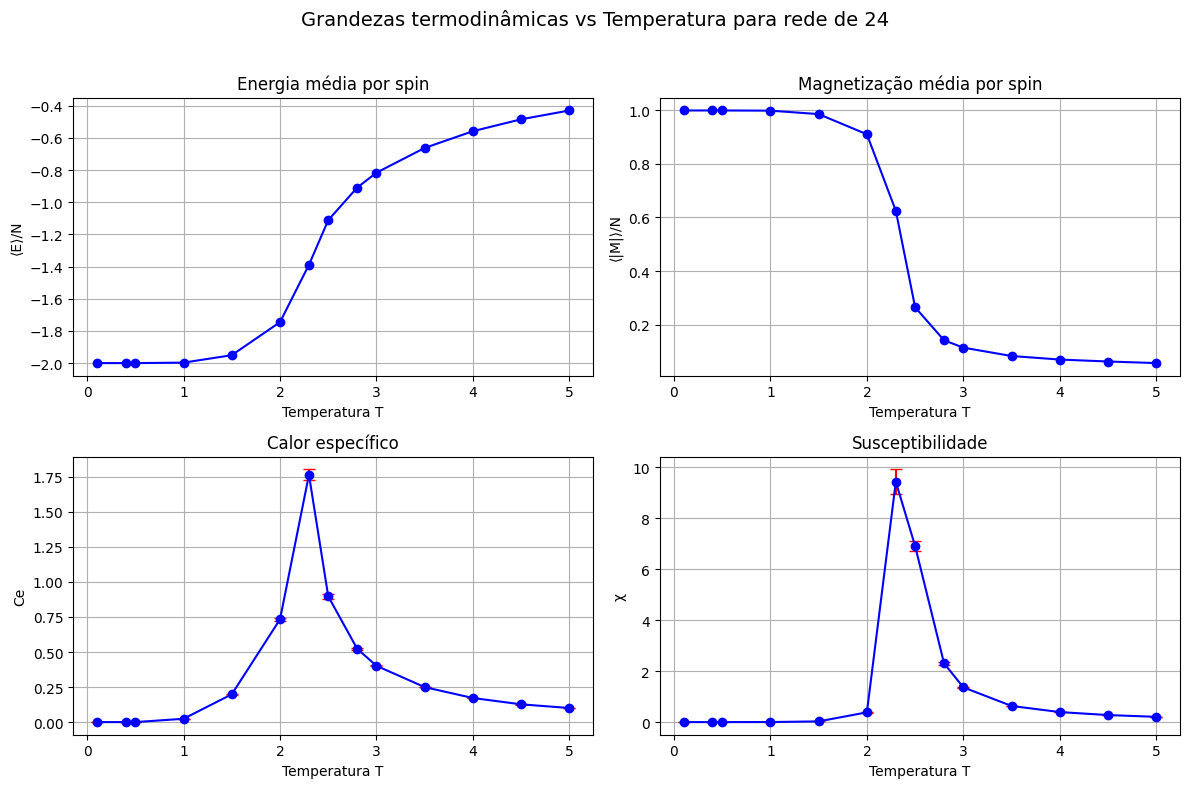

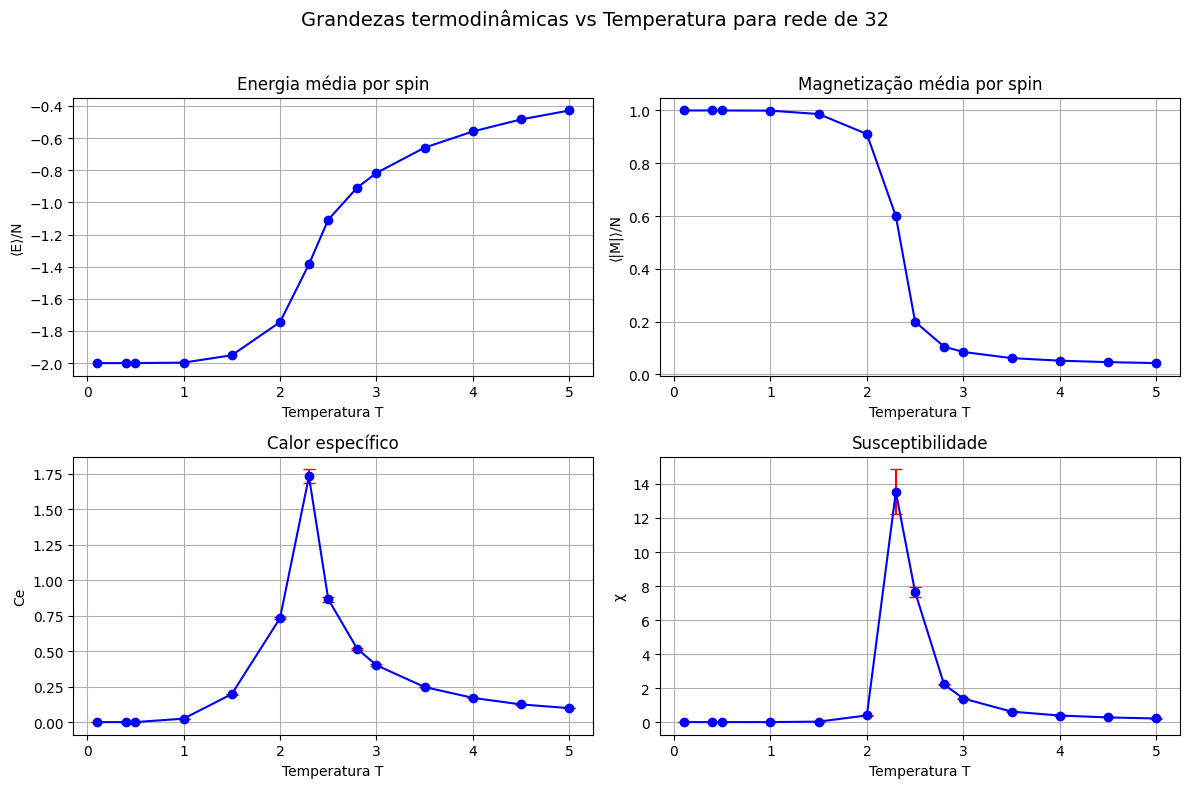

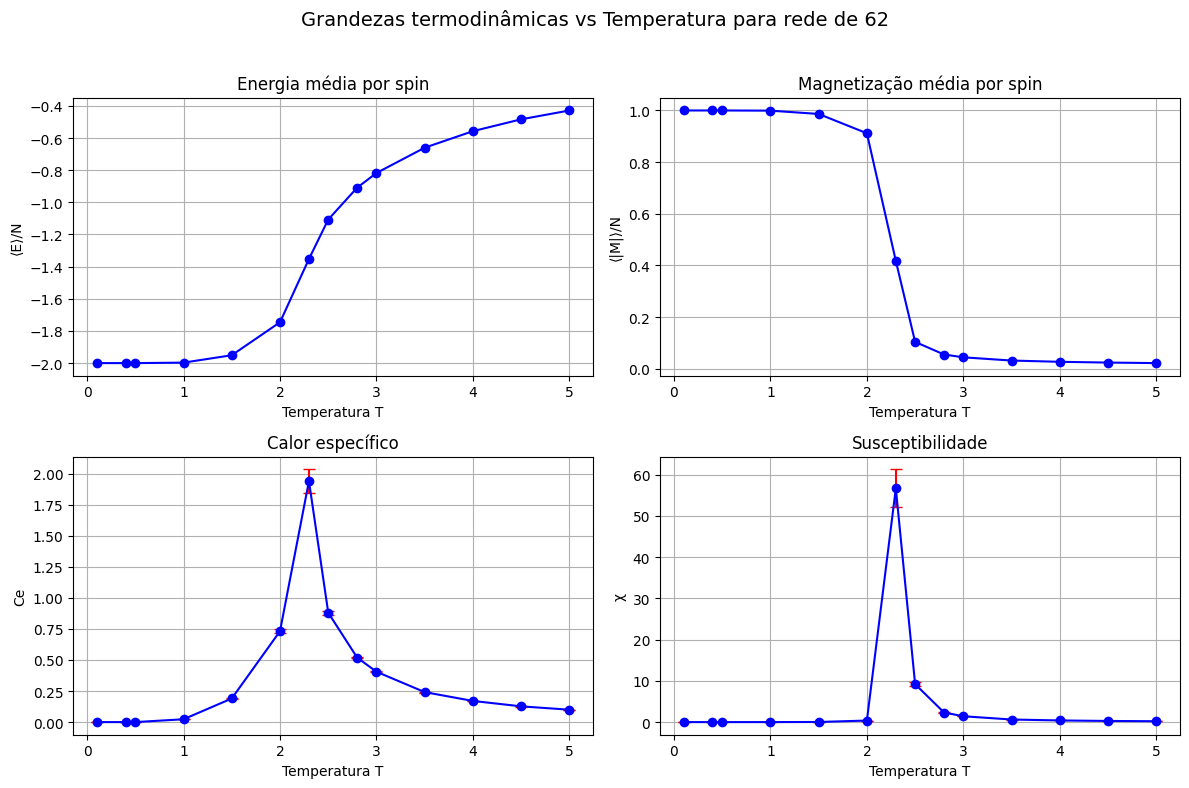

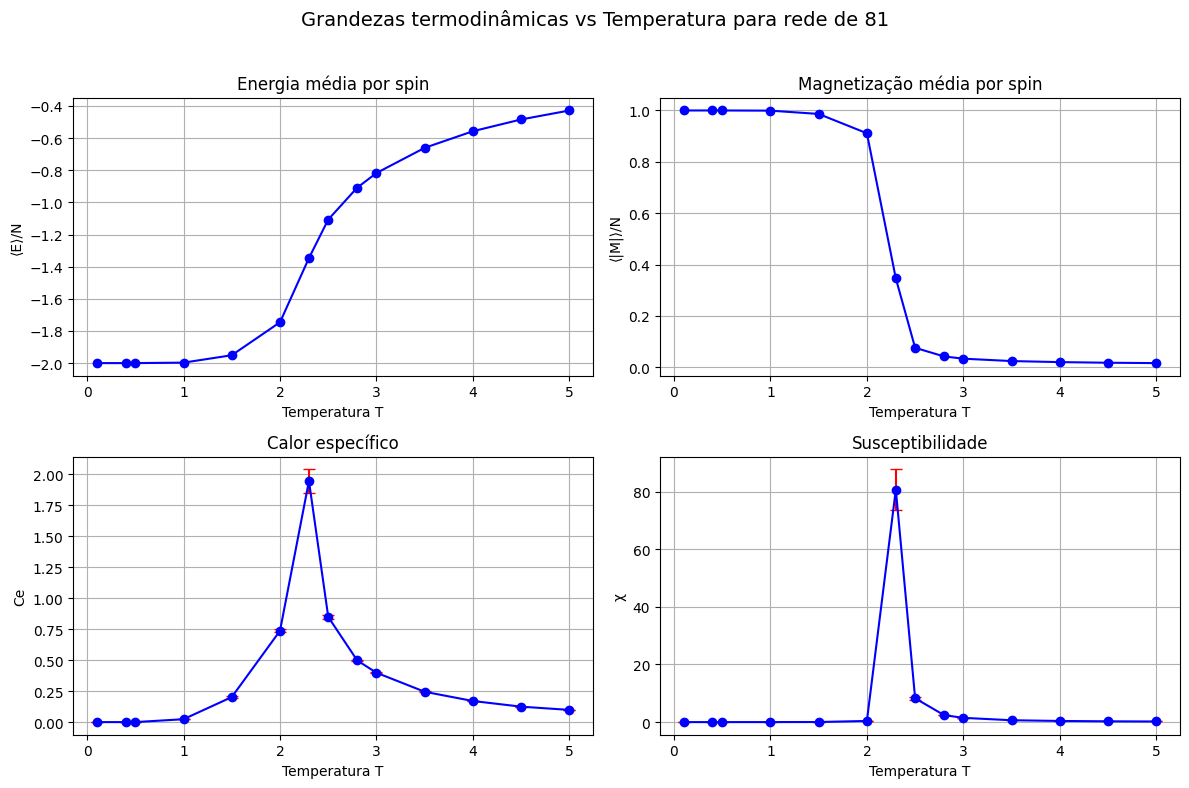

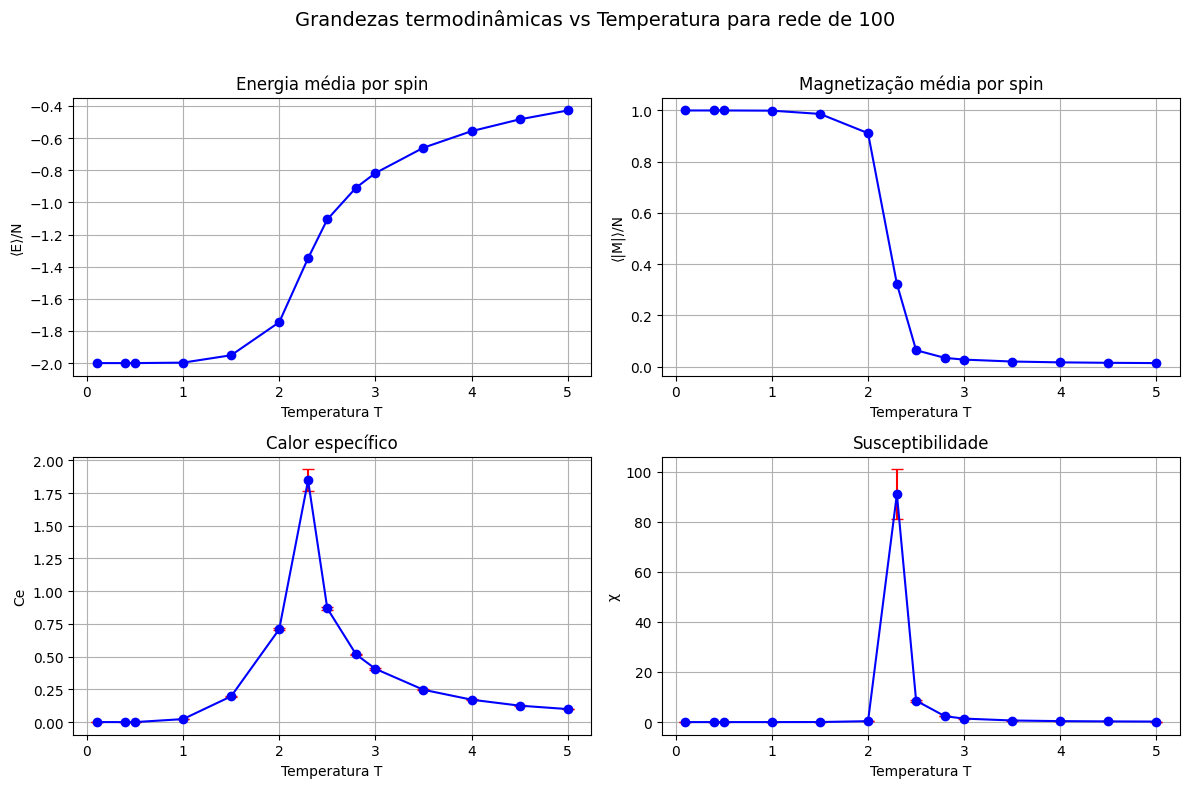

In [31]:
L_array = np.array([24, 32, 62, 81, 100])
T_array = np.array([0.1, 0.4 ,0.5 ,1.0, 1.5, 2.0, 2.3, 2.5, 2.8, 3.0,3.5,4.0,4.5,5.0])

for l_val in L_array:
  N = l_val*l_val

  (CeMedio_temp, SuscepMedio_temp, MEmedio_temp, MMmedio_temp,
 ErrCe_temp, ErrSuscep_temp, ErrME_temp, ErrMM_temp) = tratamentoestatistico(l_val, T_array, N)

  graficoGrandezasFisicas(T_array, MEmedio_temp,MMmedio_temp,CeMedio_temp, ErrCe_temp,l_val,ErrSuscep_temp)

Vamos explorar as propriedades termodinâmicas do modelo de Ising 2D fazendo simulações pelo
algoritmo de Metropolis. Para realizar as simulações você deverá escolher valores para os
parâmetros da simulação. Especificamente, você deverá escolher o tamanho do sistema, 𝐿, a
temperatura de simulação, 𝑇, o número de passos de Monte Carlo para termalização, 𝑁𝑇𝑒𝑟𝑚, e o
número de passos de Monte Carlo para calcular as médias termodinâmicas, 𝑁𝑀𝐶𝑆. \

1) Quais critérios você utilizou para escolher os valores dos parâmetros descritos acima?
Provavelmente suas escolhas iniciais precisarão ser revistas, não há problemas! Pelo
contrário, o ideal é que ao longo do trabalho você vá revendo suas escolhas, aprimorando-as,
mas quero saber quais os principais fatores que nortearam suas escolhas finais.

**Resposta:** escolhi malhas de tamanho entre 24 e 100, pois já tinha testado essas malhas anteriormente na atividade, a temperatura variando de 5.0 até 0.1, para simular desde altas temperaturas e reduzi-la até próximo de zero, os  𝑁𝑇𝑒𝑟m foram calculados com base na análise da tabela após testar algumas simulações e os 𝑁𝑀𝐶s foram divididos em n=20 blocos contendo 𝑁𝑚𝑐𝑠/𝑛 cada, começando em 10000 e reduzindo até o valor de 500 passos. O valor inicial de 10000 foi escolhido pensando na termalização das grades maiores.

2) Descreva o comportamento observado para as principais grandezas termodinâmicas –
Energia por spin, Magnetização por spin, calor específico e susceptibilidade magnética – em
função da temperatura. Ou seja, ao variar a temperatura, o que acontece com o valor destas
grandezas? Quais são os limites para baixas e altas temperaturas? Há algum pico ou vale? O
comportamento está em acordo com o que você esperava?


**Resposta:** Os resultados obtidos seguem as tendências previstas pela teoria de transições de fase em sistemas magnéticos, com características distintas em diferentes regimes de temperatura.

* Energia Média por Spin \
Observa-se que a energia média por spin diminui gradualmente à medida que a temperatura é reduzida. Em temperaturas elevadas, o valor se aproxima de zero, indicando um estado desordenado. À medida que o sistema é resfriado, a energia assume valores mais negativos, refletindo a crescente ordenação dos spins. A transição ocorre de forma contínua, sem descontinuidades abruptas, em conformidade com o esperado para sistemas magnéticos em equilíbrio.

* Magnetização Média por Spin \
A magnetização por spin apresenta um aumento progressivo conforme a temperatura diminui. Em altas temperaturas, a magnetização é próxima de zero devido à desordem térmica. À medida que o sistema é resfriado, os spins começam a se alinhar, levando a um crescimento contínuo da magnetização até atingir um valor máximo em temperaturas suficientemente baixas. Esse comportamento é característico de transições de fase de segunda ordem.

* Calor Específico e Susceptibilidade Magnética \
Ambas as grandezas exibem picos pronunciados em uma temperatura crítica (T_c), sinalizando a ocorrência de uma transição de fase. O calor específico apresenta um máximo em T_c, indicando uma maior capacidade do sistema de absorver energia nessa região. Simultaneamente, a susceptibilidade magnética atinge seu valor máximo próximo a T_c, evidenciando uma maior resposta do sistema a perturbações externas. Esses picos tornam-se mais estreitos e definidos à medida que o tamanho da rede aumenta.

3) Ao variar o tamanho do sistema, como as curvas destas grandezas em função da temperatura
se modifica? Há algum intervalo de temperaturas no qual as grandezas são independentes do
tamanho do sistema? Em regiões onde há variação com o tamanho do sistema, como a
grandeza é modificada quando 𝐿 aumenta?


**Resposta:** A análise comparativa entre diferentes tamanhos de rede revela que:

Fora da região crítica, as grandezas termodinâmicas mostram pouca dependência do tamanho do sistema.

Próximo à temperatura crítica, as flutuações tornam-se mais evidentes. Para redes menores (L = 24, 32), os picos no calor específico e na susceptibilidade são mais suaves, enquanto em redes maiores (L = 81, 100), os picos tornam-se mais agudos e localizados, aproximando-se do comportamento esperado no limite termodinâmico (L → ∞).

4) Como é o comportamento dos erros estatísticos à medida que a temperatura varia? Tem
algum valor de temperatura em torno do qual os erros são maiores? Você enxerga algum
motivo para isso? Os erros estatísticos dependem do tamanho do sistema? Como?


**Resposta:** Os erros estatísticos são mais pronunciados na região da temperatura crítica, onde as flutuações das grandezas termodinâmicas são mais intensas. Essa maior incerteza é uma consequência direta da maior sensibilidade do sistema nessa faixa de temperatura. Para sistemas maiores, os erros tendem a ser menores devido à maior amostragem estatística, embora ainda sejam perceptíveis nas proximidades de T_c.

5) Com base no comportamento encontrado, identifique possíveis fases do sistema,
descrevendo as principais características das fases encontradas. \
6) Estime, utilizando os dados das suas simulações, a temperatura de transição de fase do
sistema no limite termodinâmico, i.e., para o limite em que o tamanho do sistema é infinito

**Resposta:** O estudo revela a existência de duas fases distintas no sistema magnético simulados. Na fase ordenada (T < T_c), observa-se baixa energia por spin e alta magnetização, caracterizando um estado ferromagnético, com calor específico e susceptibilidade magnética relativamente baixos. Já na fase desordenada (T > T_c), a energia aproxima-se de zero e a magnetização torna-se insignificante, indicando desordem térmica, enquanto o calor específico e susceptibilidade apresentam valores reduzidos. A região crítica próxima a T_c mostra picos nessas grandezas, típicos de uma transição de fase contínua.

**Resposta:** A temperatura crítica no limite termodinâmico foi estimada através da extrapolação dos dados para diferentes tamanhos de rede (L = 24 a 100). Verificou-se que T_c(L) aumenta com o tamanho do sistema, seguindo o comportamento esperado. A análise sugere T_c(∞) ≈ 2.30 ± 0.3 no limite termodinâmico, valor consistente com o valor teórico esperado (2.269). Esses resultados corroboram as previsões teóricas para transições de fase em sistemas magnéticos.